In [2]:
import segyio
import numpy as np
import matplotlib.pyplot as plt

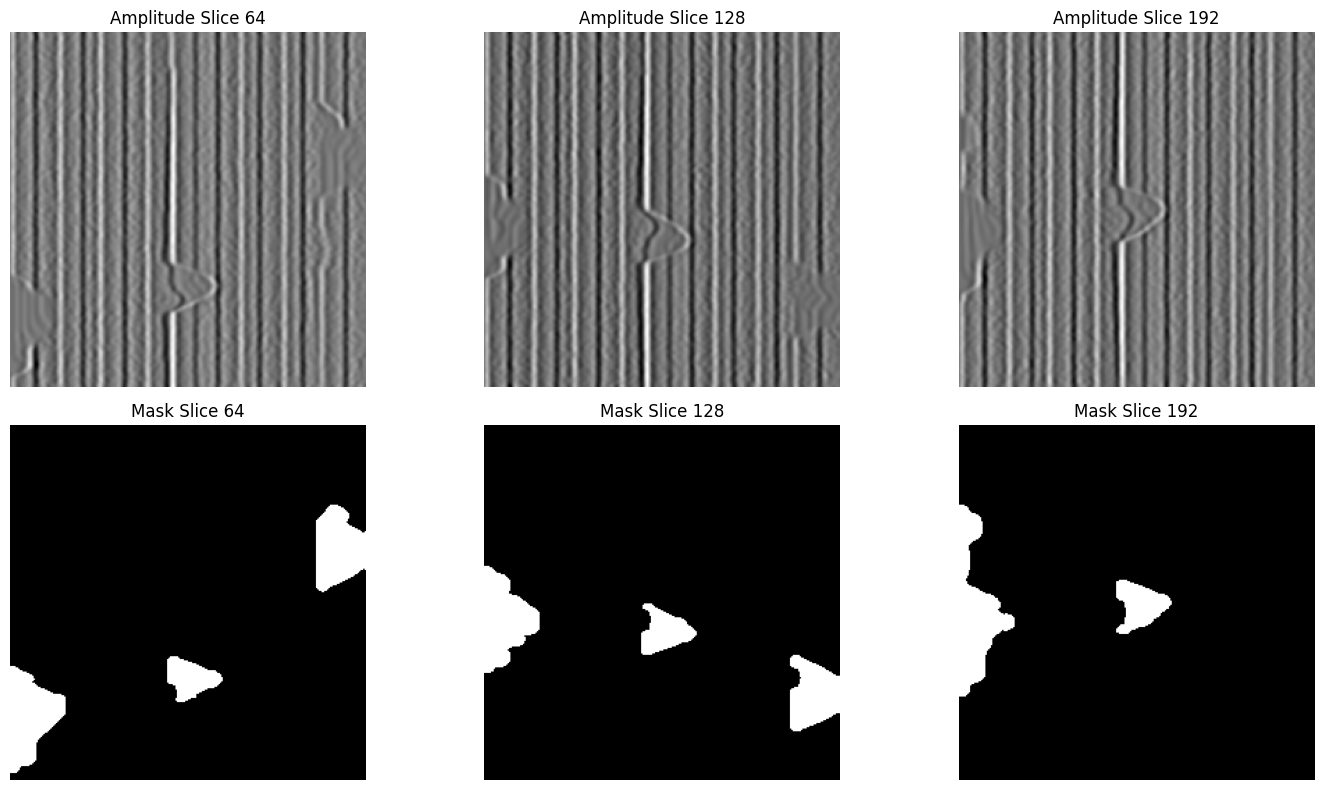

In [3]:
amp_file = "/home/dmatveev/workdir/rosneft_segmentation/data/sabamrine/seismic/0.dat"
mask_file = "/home/dmatveev/workdir/rosneft_segmentation/data/sabamrine/label/0.dat"

# Define the expected shape and dtypes for the data
cube_shape = (256, 256, 256)
amp_dtype = np.float32    # for seismic amplitude data
mask_dtype = np.uint8     # for binary mask data (change if different)

def load_cube_raw(filename, shape, dtype):
    """
    Load a 3D cube from a raw binary file.
    """
    data = np.fromfile(filename, dtype=dtype)
    if data.size != np.prod(shape):
        raise ValueError(f"Data size {data.size} does not match expected shape {shape}")
    return data.reshape(shape)

# Load amplitude and mask cubes
cube_amp = load_cube_raw(amp_file, cube_shape, amp_dtype)
cube_mask = load_cube_raw(mask_file, cube_shape, mask_dtype)

# Choose slice indices; here we pick three slices along the first axis (depth)
depth = cube_amp.shape[0]
slices = [depth // 4, depth // 2, 3 * depth // 4]

# Plot the selected slices from both amplitude and mask volumes
fig, axs = plt.subplots(2, len(slices), figsize=(15, 8))

for idx, slice_idx in enumerate(slices):
    # Display amplitude slice
    axs[0, idx].imshow(cube_amp[slice_idx, :, :], cmap='gray')
    axs[0, idx].set_title(f'Amplitude Slice {slice_idx}')
    axs[0, idx].axis('off')
    
    # Display corresponding mask slice
    axs[1, idx].imshow(cube_mask[slice_idx, :, :], cmap='gray')
    axs[1, idx].set_title(f'Mask Slice {slice_idx}')
    axs[1, idx].axis('off')

plt.tight_layout()
plt.show()

In [4]:
import os
import cv2
import numpy as np
import torch
import random
import matplotlib.pyplot as plt

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [5]:
def load_cube(filepath, shape=(256, 256, 256), dtype=np.float32):
    """
    Загрузка 3D-куба из raw бинарного файла.
    """
    data = np.fromfile(filepath, dtype=dtype)
    if data.size != np.prod(shape):
        raise ValueError(f"Размер данных {data.size} не совпадает с ожидаемой формой {shape} для файла {filepath}")
    return data.reshape(shape)

def compute_metrics(pred, target, threshold=0.5):
    """
    Вычисление IoU и Dice для бинарных масок.
    """
    pred_bin = (pred > threshold).astype(np.uint8)
    target_bin = (target > threshold).astype(np.uint8)

    intersection = np.logical_and(pred_bin, target_bin).sum()
    union = np.logical_or(pred_bin, target_bin).sum()
    iou = intersection / union if union != 0 else 0.0

    pred_sum = pred_bin.sum()
    target_sum = target_bin.sum()
    dice = (2.0 * intersection) / (pred_sum + target_sum) if (pred_sum + target_sum) != 0 else 0.0

    return iou, dice

In [6]:
seismic_dir = "/home/dmatveev/workdir/rosneft_segmentation/data/sabamrine/seismic"
label_dir   = "/home/dmatveev/workdir/rosneft_segmentation/data/sabamrine/label"

# Пути к модели SAM2
sam2_checkpoint = "/home/dmatveev/workdir/rosneft_segmentation/models/sam2.1_hiera_base_plus.pt"  # вес модели
model_cfg = "configs/sam2.1/sam2.1_hiera_b+.yaml"  # путь к конфигу

# Построение модели и предиктора
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)

# Список всех файлов в папке с сейсмикой
all_files = sorted(os.listdir(seismic_dir))
# Выбираем n случайных кубов
n = 5  # можно изменить количество кубов
selected_files = random.sample(all_files, n)

# Количество случайных срезов из каждого куба
m = 3  # можно изменить число срезов

In [8]:
pred_mask

array([[1, 0, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 1, 0],
       ...,
       [1, 1, 1, ..., 0, 1, 0],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 0, 0, ..., 0, 0, 0]], shape=(256, 256), dtype=uint8)

In [9]:
label_slice

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], shape=(256, 256), dtype=uint8)

Файл: 4.dat, Срез: 111, IoU: 0.1277, Dice: 0.2264


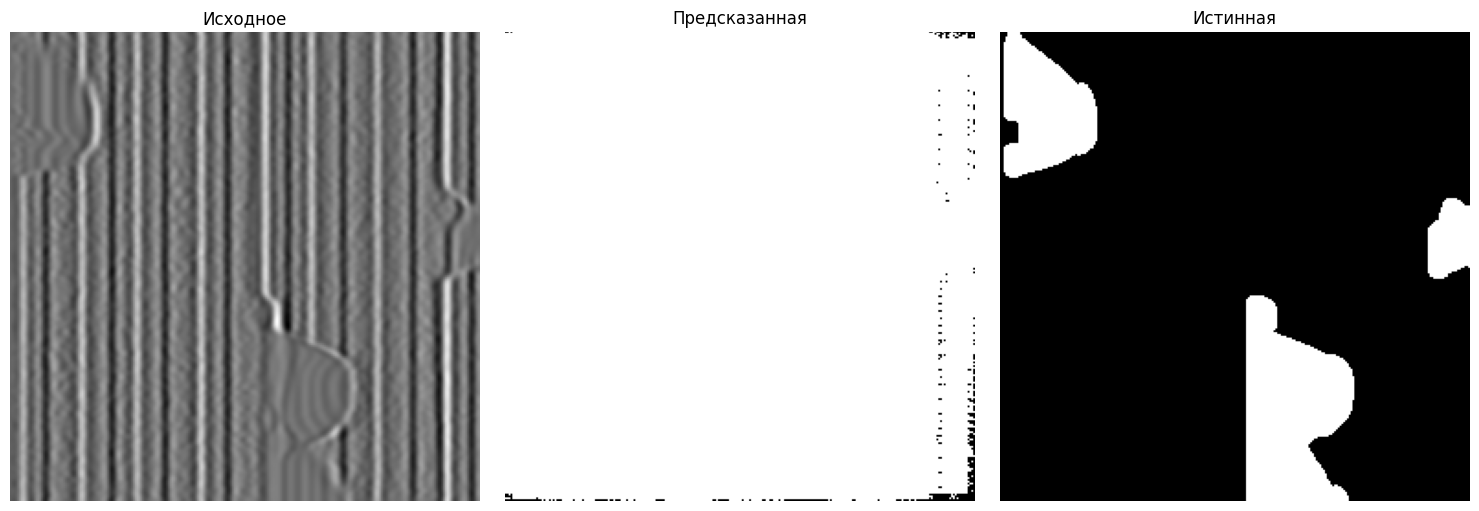

Файл: 4.dat, Срез: 211, IoU: 0.1291, Dice: 0.2287


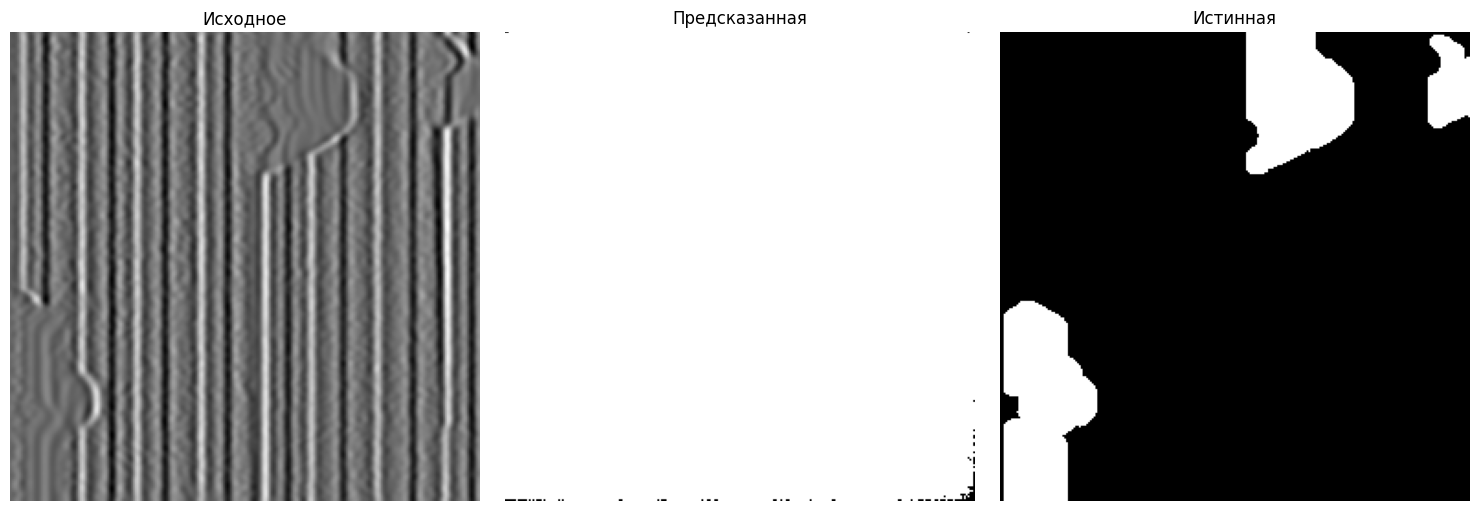

Файл: 4.dat, Срез: 44, IoU: 0.0105, Dice: 0.0208


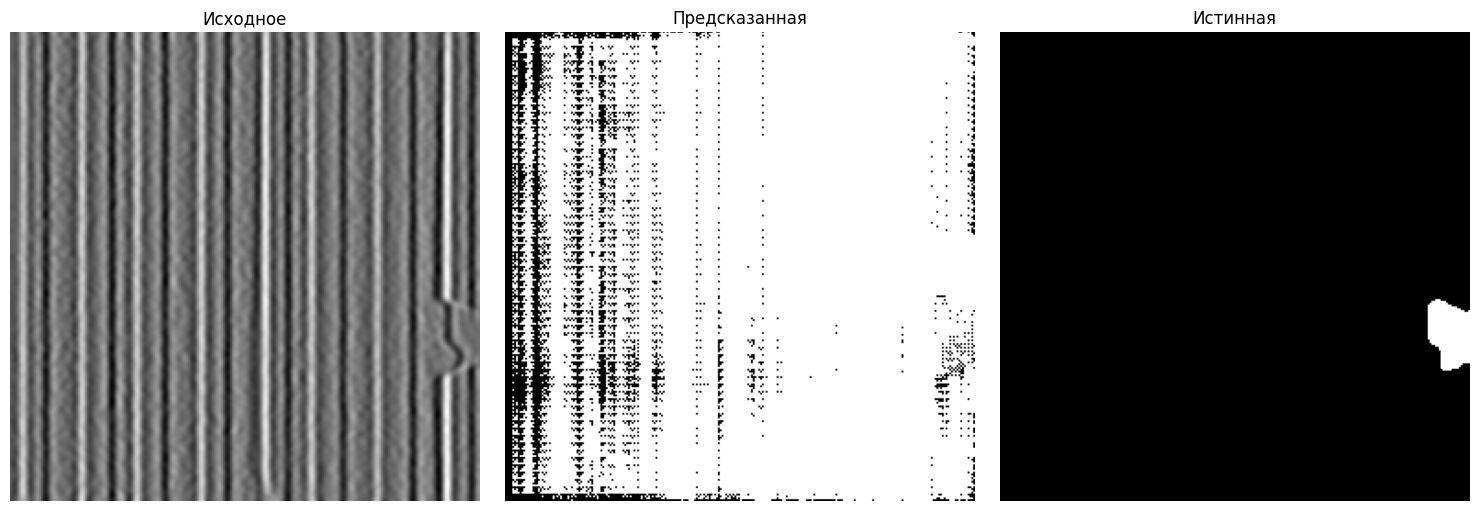

Файл: 20.dat, Срез: 17, IoU: 0.1814, Dice: 0.3071


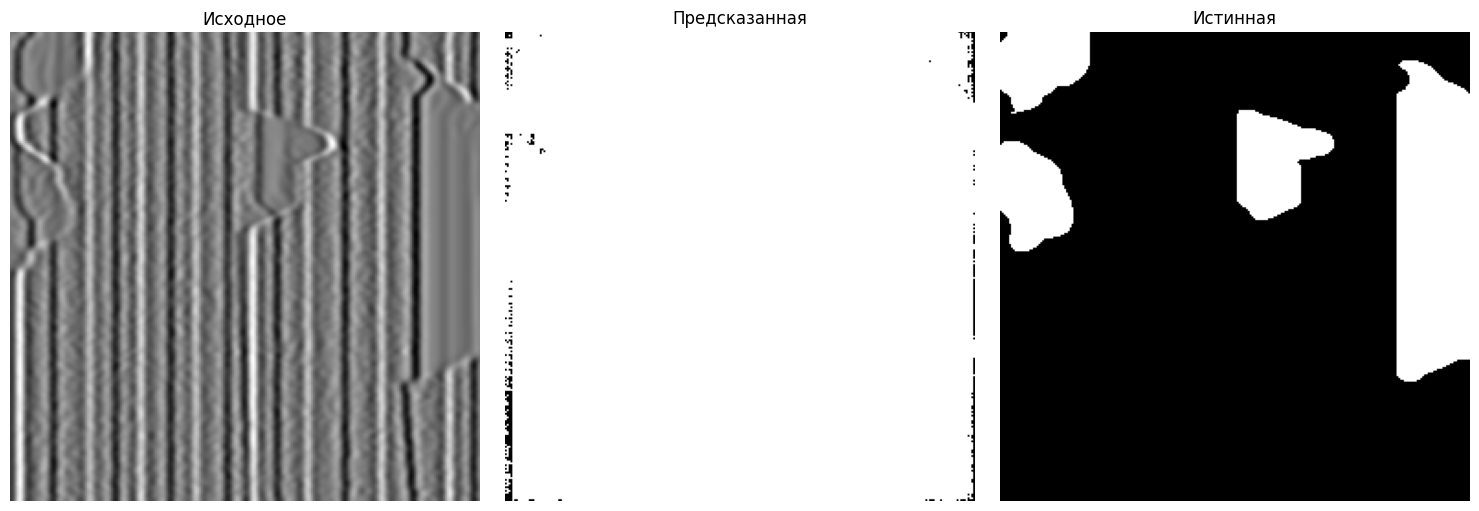

Файл: 20.dat, Срез: 43, IoU: 0.2036, Dice: 0.3384


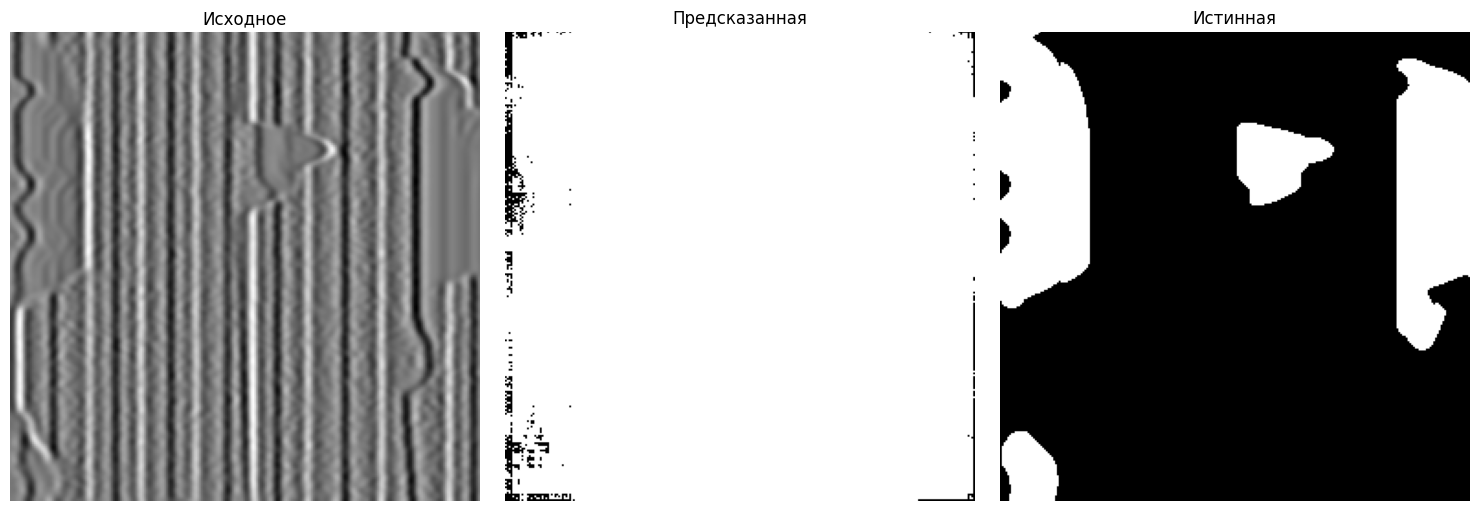

Файл: 20.dat, Срез: 19, IoU: 0.0875, Dice: 0.1609


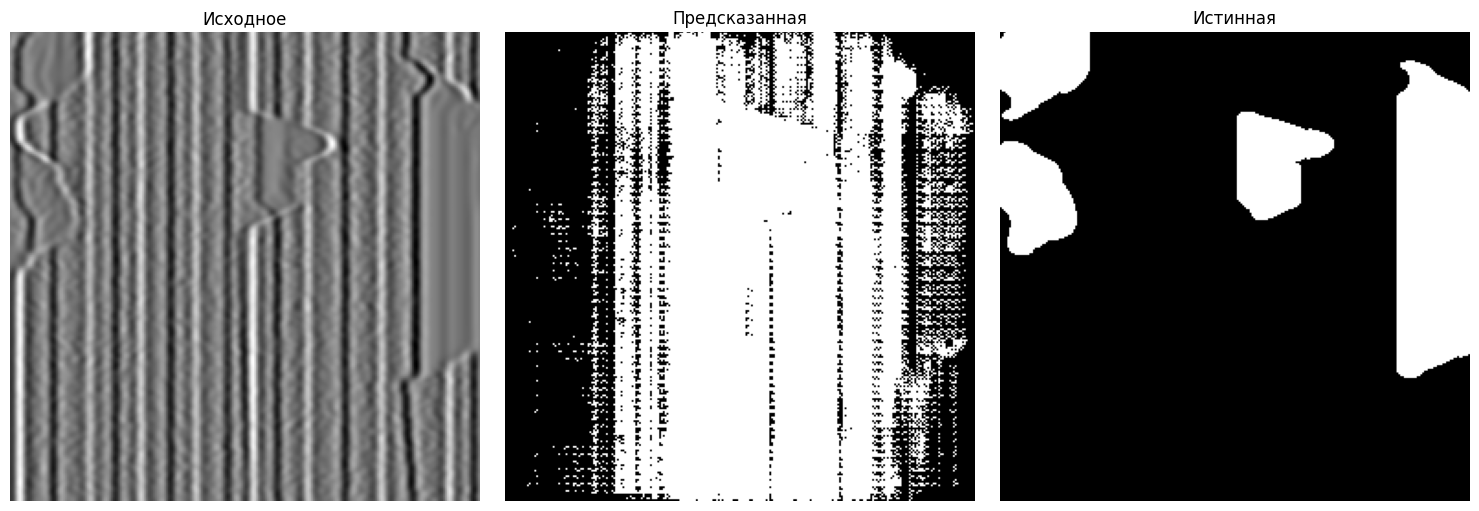

Файл: 7.dat, Срез: 145, IoU: 0.2509, Dice: 0.4011


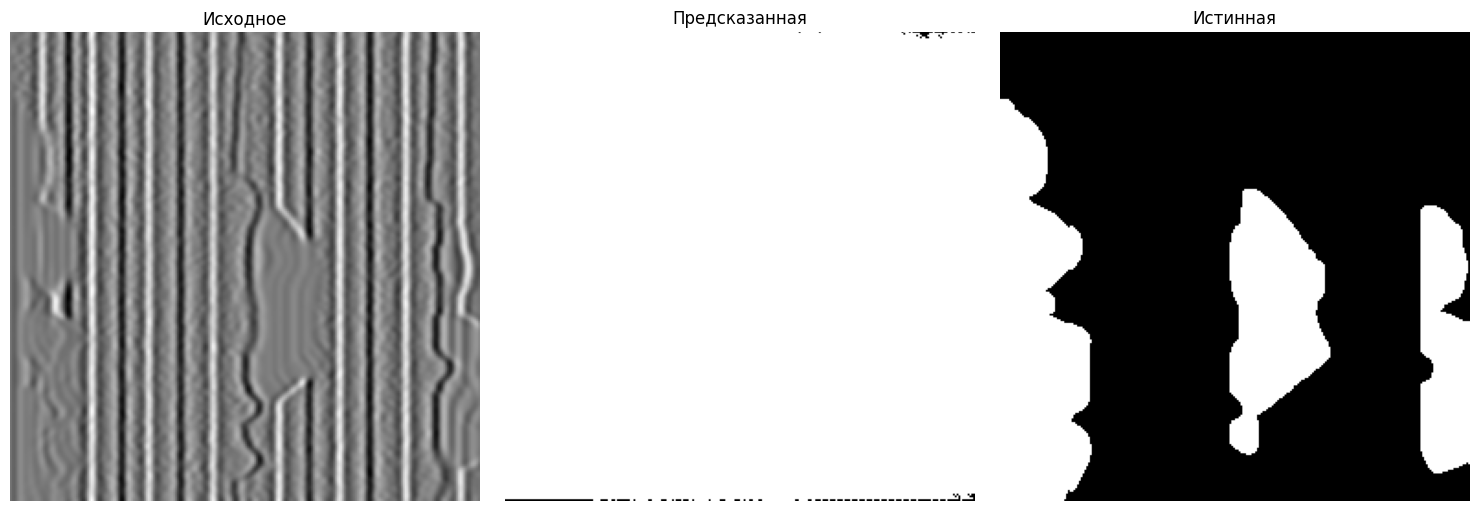

Файл: 7.dat, Срез: 114, IoU: 0.1550, Dice: 0.2685


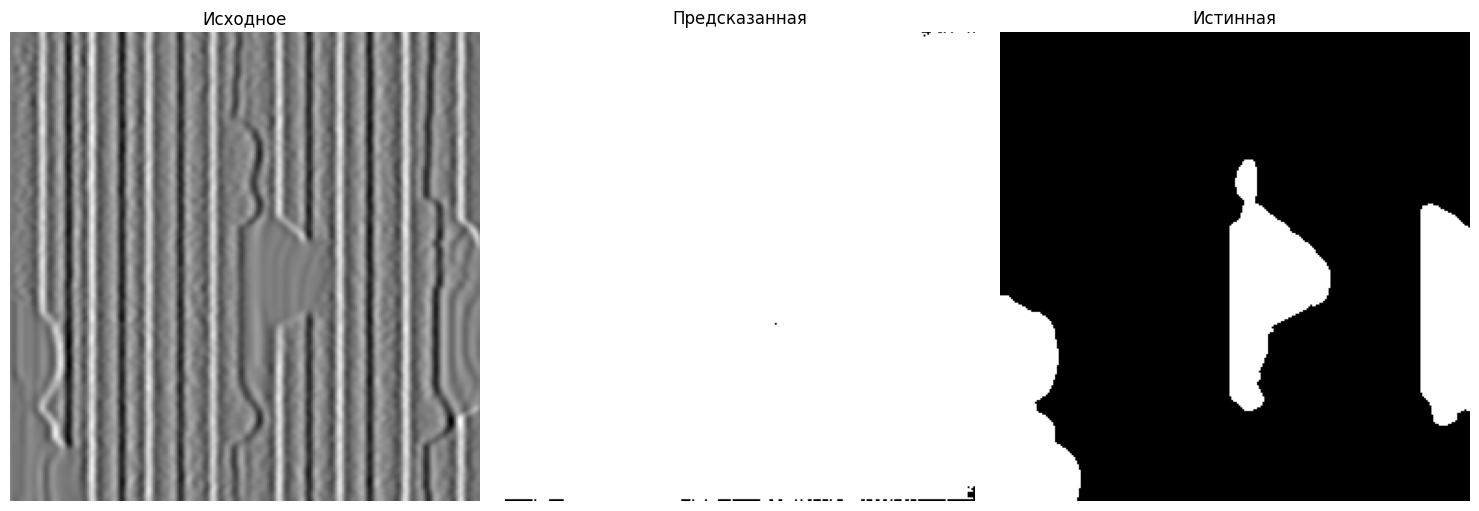

Файл: 7.dat, Срез: 124, IoU: 0.1841, Dice: 0.3110


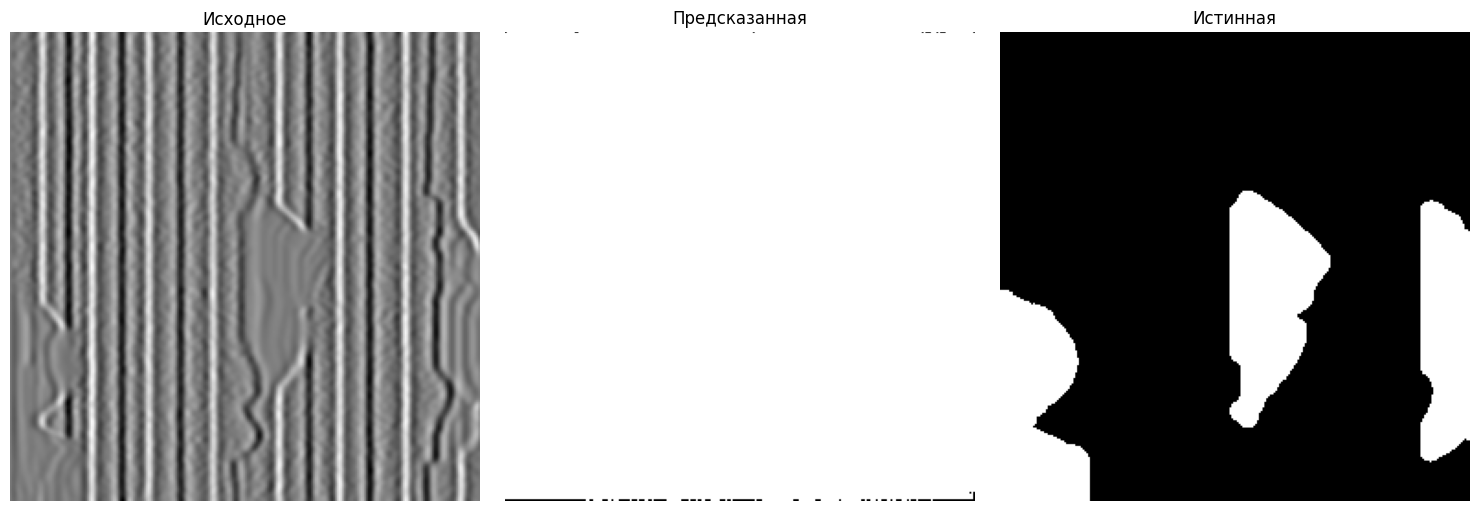

Файл: 3.dat, Срез: 166, IoU: 0.1564, Dice: 0.2705


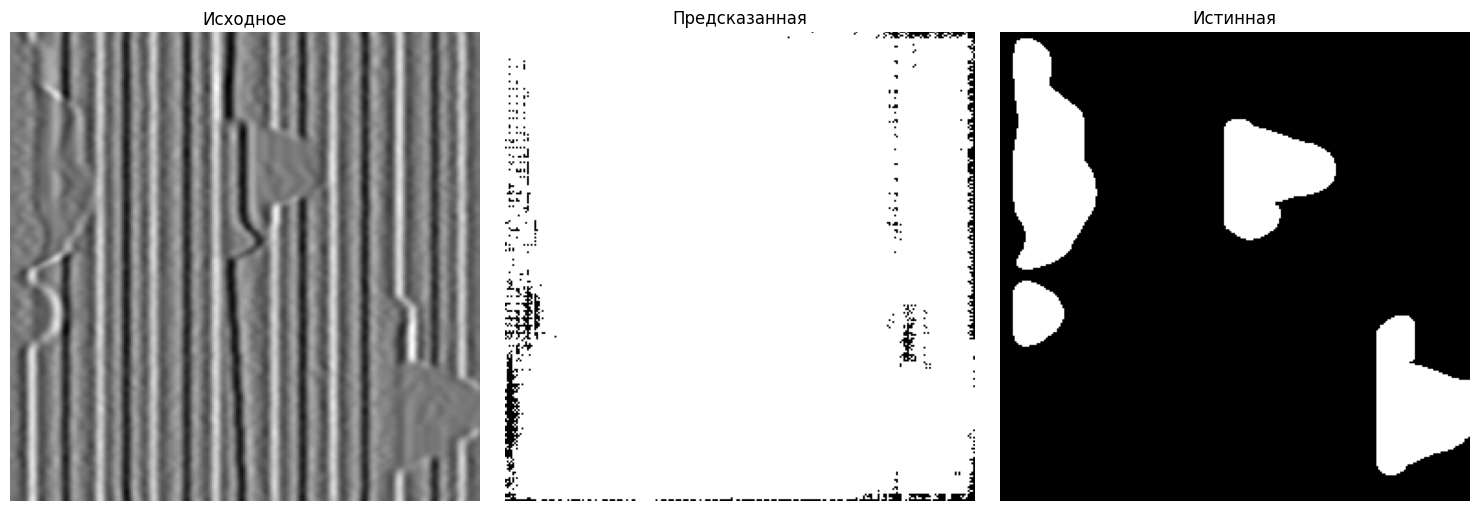

Файл: 3.dat, Срез: 100, IoU: 0.2578, Dice: 0.4099


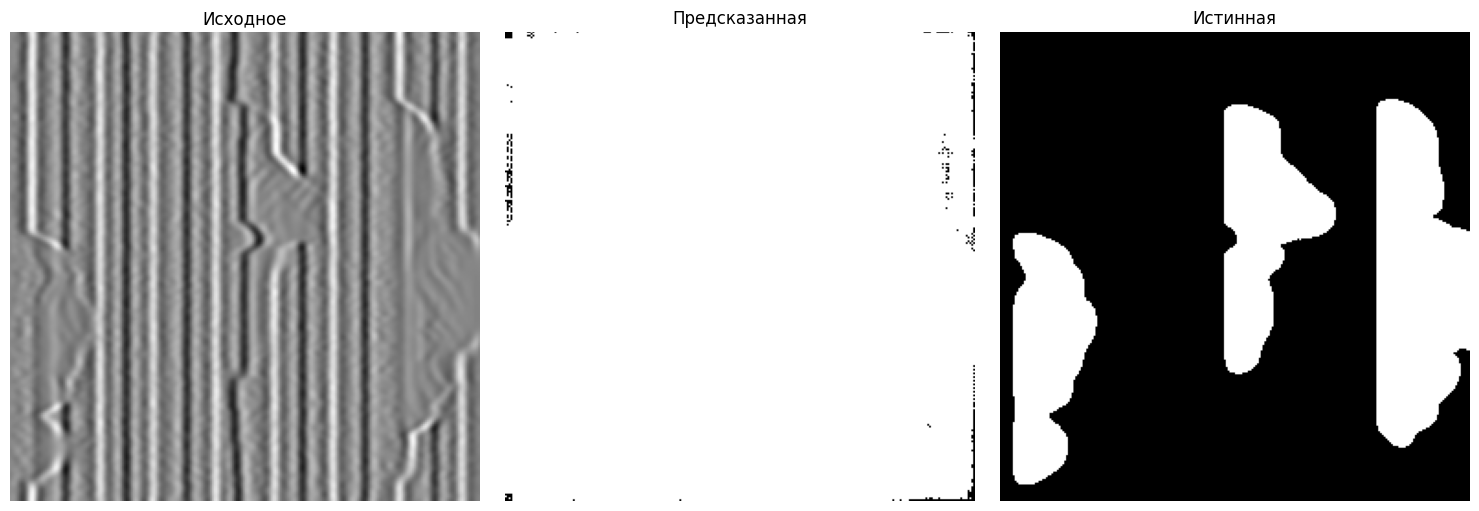

Файл: 3.dat, Срез: 135, IoU: 0.1582, Dice: 0.2732


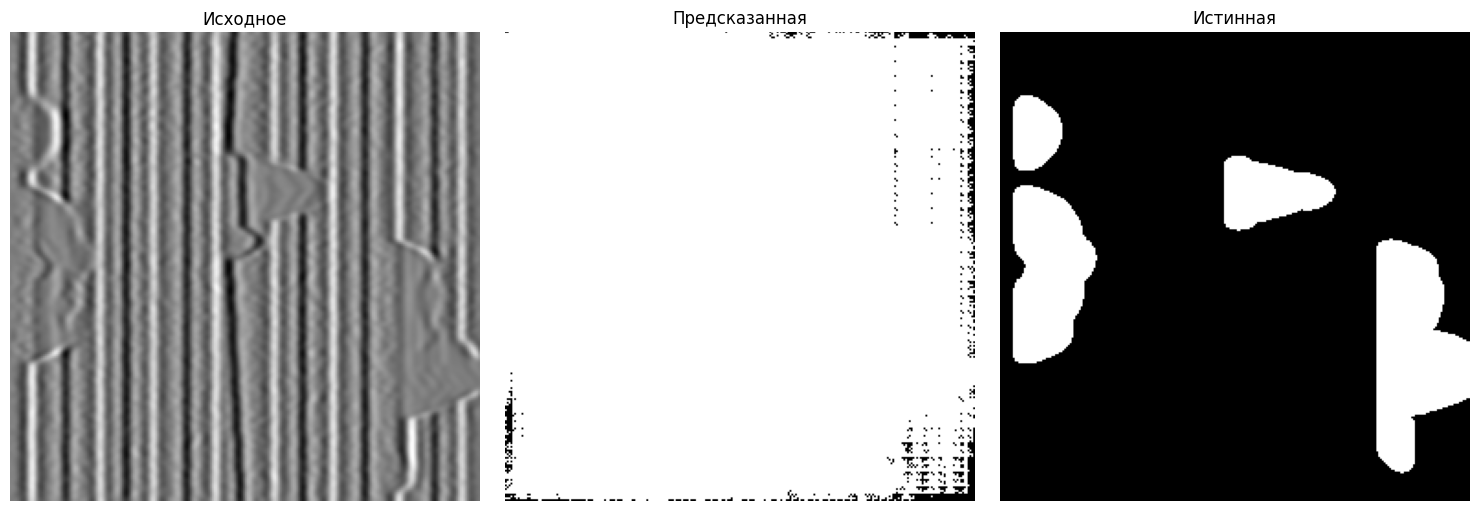

Файл: 31.dat, Срез: 57, IoU: 0.1475, Dice: 0.2570


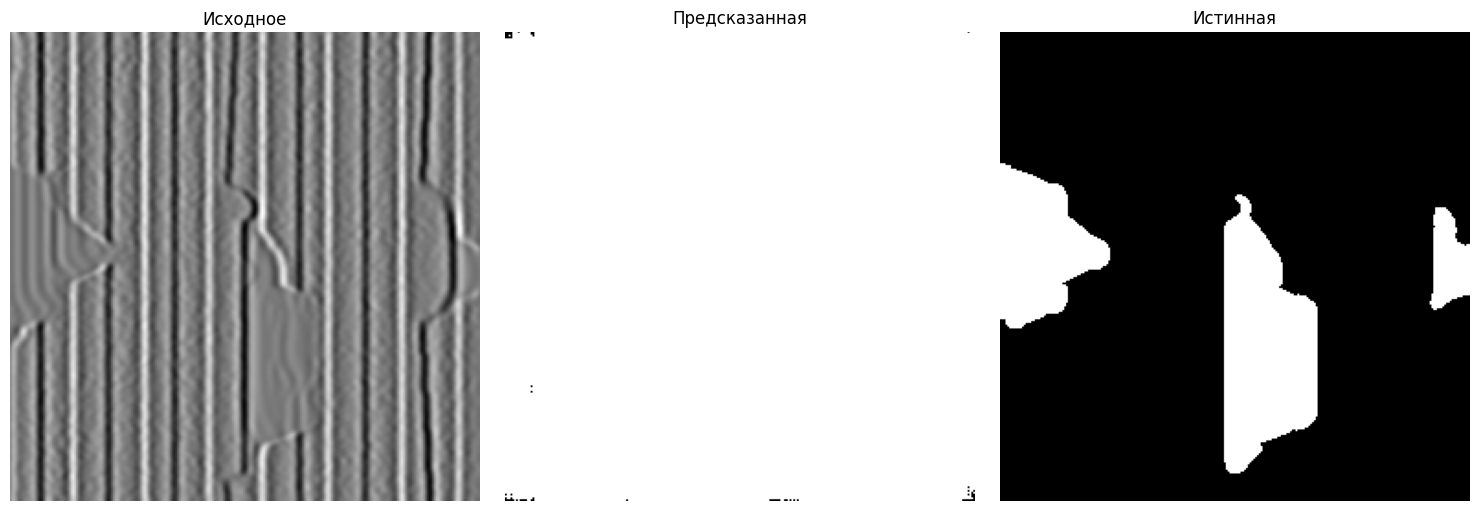

Файл: 31.dat, Срез: 100, IoU: 0.1644, Dice: 0.2824


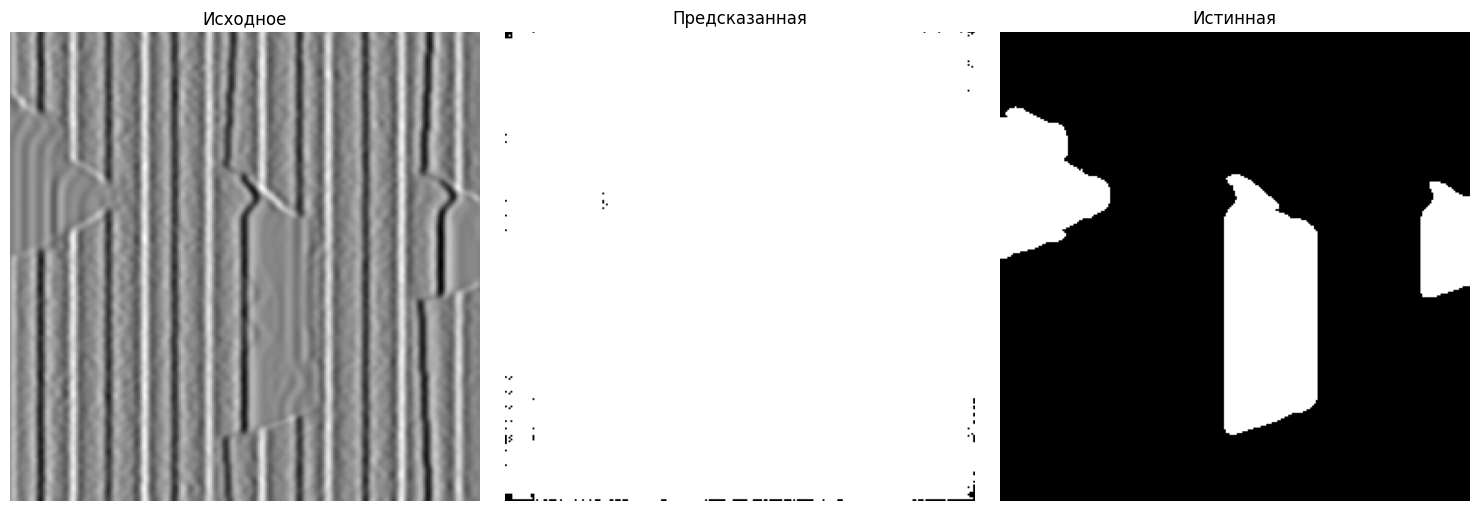

Файл: 31.dat, Срез: 246, IoU: 0.2412, Dice: 0.3886


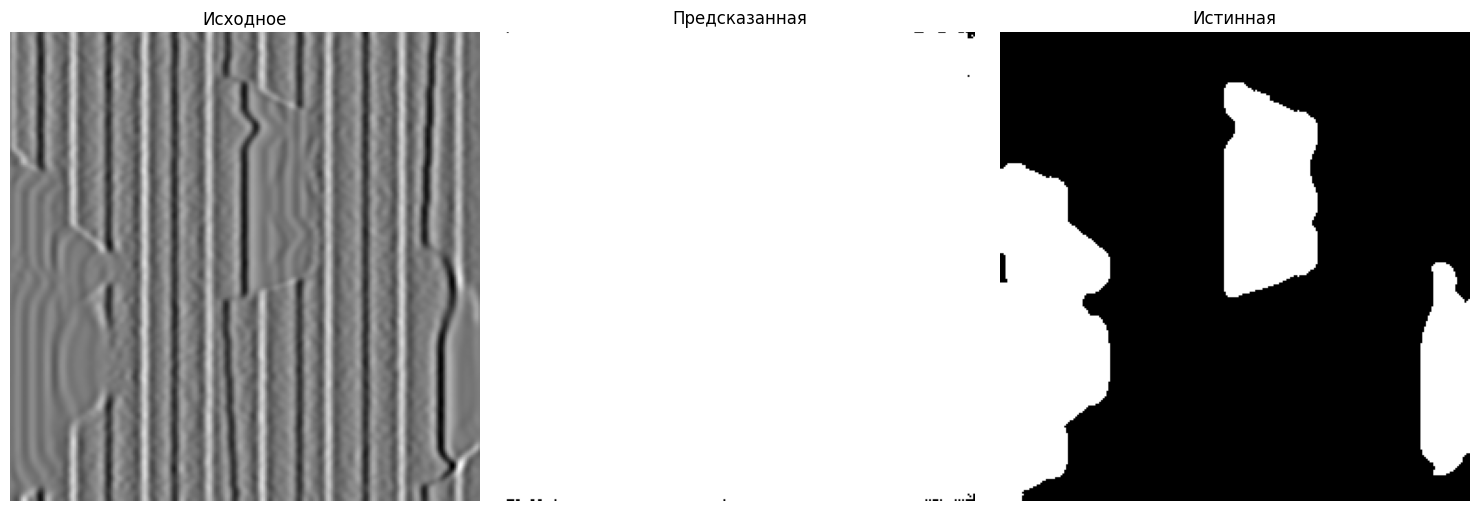

In [7]:
# Списки для накопления метрик
ious = []
dices = []

for filename in selected_files:
    seismic_path = os.path.join(seismic_dir, filename)
    label_path   = os.path.join(label_dir, filename)  # предполагаем, что имена файлов совпадают

    # Загружаем 3D-кубы (сейсмику и метки)
    seismic_cube = load_cube(seismic_path, shape=(256, 256, 256), dtype=np.float32)
    label_cube   = load_cube(label_path, shape=(256, 256, 256), dtype=np.uint8)

    depth = seismic_cube.shape[0]
    # Выбираем m случайных индексов срезов вдоль оси глубины
    slice_indices = random.sample(range(depth), m)

    for slice_idx in slice_indices:
        # Извлекаем срез из куба
        seismic_slice = seismic_cube[slice_idx, :, :]
        label_slice   = label_cube[slice_idx, :, :]

        # Если изображение одноканальное, создаём 3-канальное
        seismic_img = np.stack([seismic_slice, seismic_slice, seismic_slice], axis=-1)

        predictor.set_image(seismic_img)

        # Выбираем случайную точку из метки (предполагаем, что ненулевые пиксели — объект интереса)
        pos_indices = np.argwhere(label_slice > 0)
        if len(pos_indices) > 0:
            chosen_idx = random.choice(pos_indices)
            # SAM ожидает координаты в формате (x, y) = (колонка, строка)
            prompt_point = np.array([[chosen_idx[1], chosen_idx[0]]], dtype=np.float32)
            point_label = np.array([1], dtype=np.int32)  # положительный промпт
            # Выполняем предсказание с точечным промптом
            masks, scores, logits = predictor.predict(point_coords=prompt_point, point_labels=point_label)
        else:
            # Если нет положительных точек, делаем предсказание без промпта
            masks, scores, logits = predictor.predict()

        # Если предсказания есть, берем первое, иначе создаем пустую маску
        if len(masks) > 0:
            pred_mask = masks[0]
        else:
            pred_mask = np.zeros_like(label_slice)

        # При необходимости изменяем размер предсказанной маски до размера метки
        pred_mask = cv2.resize(pred_mask.astype(np.uint8), (label_slice.shape[1], label_slice.shape[0]))

        # Вычисляем метрики
        iou, dice = compute_metrics(pred_mask, label_slice)
        ious.append(iou)
        dices.append(dice)

        print(f"Файл: {filename}, Срез: {slice_idx}, IoU: {iou:.4f}, Dice: {dice:.4f}")

        # Визуализация: исходный срез, предсказанная маска и истинная маска
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(seismic_slice, cmap='gray')
        axes[0].set_title("Исходное")
        axes[0].axis('off')

        axes[1].imshow(pred_mask, cmap='gray')
        axes[1].set_title("Предсказанная")
        axes[1].axis('off')

        axes[2].imshow(label_slice, cmap='gray')
        axes[2].set_title("Истинная")
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

In [9]:
print(f"\nСреднее IoU: {np.mean(ious):.4f}, Среднее Dice: {np.mean(dices):.4f}")



Среднее IoU: 0.1633, Среднее Dice: 0.2727
